In [10]:
import pandas as pd
import xarray as xr
import glob
import os
import netCDF4
import scipy
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
#from oceans.filters import lanc  #pip install ocean
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs

In [11]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [12]:
#/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc


region = 'NORTHSEA'

start_time = '01/01/2004'

end_time = '31/12/2004'

if region in {'BALTIC'} :
    max_lat = 66.0
    min_lat = 53.0
    max_lon = 31.0
    min_lon = 9.0
    
    #tg_dac = xr.open_dataset('/nfs/DGFI8/H/work_marcello/giussani_machinelearning_data/TG_DACcorrected/baltic_tg_gesla_dac.nc')
    tg_dac = xr.open_dataset('/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc')

    lon = np.asarray(tg_dac.lon.values,dtype=float)
    lat = np.asarray(tg_dac.lat.values,dtype=float)    
    
#     # Exclude tide gauges in Kattegat and Skagerrag, because out of the training area

    indices =  ~( (lon < 13.0) & (lon > 9) &   \
                              (lat < 66.0) & (lat > 56.0)) & ((lon < max_lon) & (lon > min_lon) &   \
                              (lat < max_lat) & (lat > min_lat))   
    

    # Altimetry
    alti_full = pd.read_csv(r'/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_baltic2004_01to12.csv',index_col=[0],parse_dates=[0])
    
    #model
    copernicus_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_copernicus.csv',index_col=[7],parse_dates=[7])
    copernicus_full['sla_predicted'] = copernicus_full['sla_predicted'] 

    #cmems
    cmems_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_cmems_allsat.csv',index_col=[5],parse_dates=[5])    
    

elif region in {'NORTHSEA'} :
    
    max_lat = 61.0
    min_lat = 50.0
    max_lon = 12.2
    min_lon = -4.0  
    
    tg_dac = xr.open_dataset('/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc')
    
    lon = np.asarray(tg_dac.lon.values,dtype=float)
    lat = np.asarray(tg_dac.lat.values,dtype=float)
    
    indices =  ( (lon < max_lon) & (lon > min_lon) &   \
                              (lat < max_lat) & (lat > min_lat) )    

    # Altimetry
    alti_full = pd.read_csv(r'/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_northsea2004_01to12.csv',index_col=[0],parse_dates=[0])
    
    #model
    copernicus_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_copernicus.csv',index_col=[7],parse_dates=[7])
    copernicus_full['sla_predicted'] = copernicus_full['sla_predicted'] 

    #cmems
    cmems_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_cmems_NORTHSEA_allsat.csv',index_col=[5],parse_dates=[5])



tg_dac = tg_dac.sel({'x':indices })

tg_dac


<xarray.Dataset>
Dimensions:  (time: 32677, x: 35)
Coordinates:
    lon      (x) float64 1.751 -1.875 -3.975 0.05703 ... 11.8 8.433 1.318 -2.075
    lat      (x) float64 52.47 50.71 51.57 50.78 ... 57.68 55.47 51.12 57.14
  * time     (time) datetime64[ns] 1993-01-01 1993-01-01T06:00:00 ... 2015-05-15
    index    (x) int64 ...
Dimensions without coordinates: x
Data variables:
    sla      (time, x) float64 ...
Attributes:
    info:     GESLAv2 dataset; DAC and Tide removed (with 40-h loess filter).

In [13]:
# Distance vs TG
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    
    
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 -lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

    return np.round(res, 2)

/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(12)
Coordinates:
    lon      float64 1.751
    lat      float64 52.47
    index    int64 12
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.273062  0.883274  0.786098
model  0.273062  1.000000  0.254230  0.410983
cmems  0.883274  0.254230  1.000000  0.781875
TG     0.786098  0.410983  0.781875  1.000000
RMSE ML TG
0.06447234723618937
RMSE CMEMS TG
0.06802552961548289


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(28)
Coordinates:
    lon      float64 -3.975
    lat      float64 51.57
    index    int64 28
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.135359  0.891242  0.780432
model  0.135359  1.000000  0.208289  0.005459
cmems  0.891242  0.208289  1.000000  0.660294
TG     0.780432  0.005459  0.660294  1.000000
RMSE ML TG
0.05981268803592136
RMSE CMEMS TG
0.06638742239421135


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(35)
Coordinates:
    lon      float64 0.05703
    lat      float64 50.78
    index    int64 35
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.093482  0.599473  0.660663
model  0.093482  1.000000 -0.025507  0.105873
cmems  0.599473 -0.025507  1.000000  0.605200
TG     0.660663  0.105873  0.605200  1.000000
RMSE ML TG
0.06499756626823784
RMSE CMEMS TG
0.07013408387640893


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(42)
Coordinates:
    lon      float64 0.7431
    lat      float64 51.44
    index    int64 42
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML    model     cmems        TG
ML     1.000000  0.23506  0.794808  0.633499
model  0.235060  1.00000  0.291080  0.436900
cmems  0.794808  0.29108  1.000000  0.630799
TG     0.633499  0.43690  0.630799  1.000000
RMSE ML TG
0.09095287002856775
RMSE CMEMS TG
0.08903170074994962


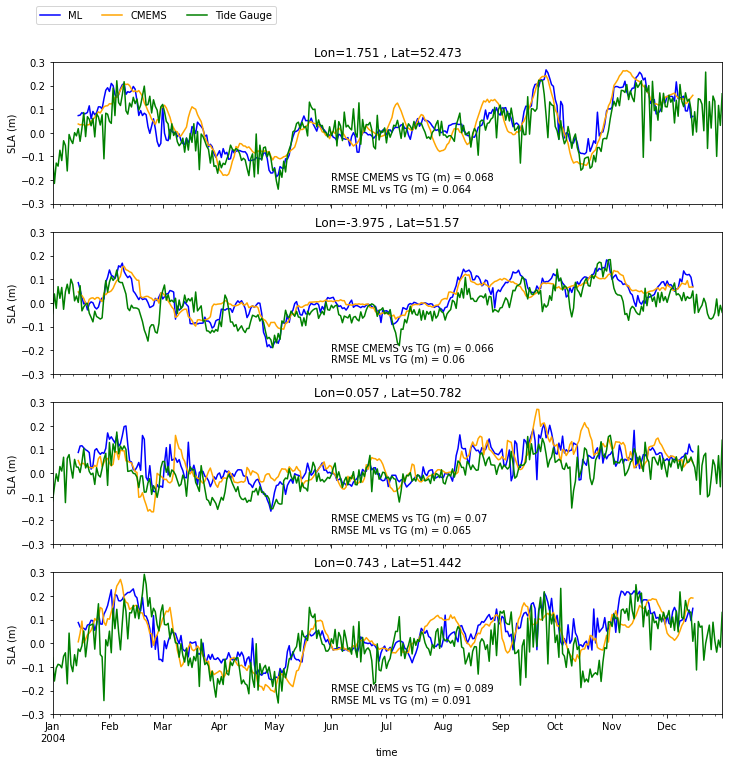

In [14]:
# FOR THE PAPER

# list_names = ['landsortnorra-010-sweden-smhi','gedser-gedser-denmark-dmi',\
#               'visby-026-sweden-smhi']

#list_names = ['skanor-019-sweden-smhi','kungsholmsfort-008-sweden-smhi',\
#              'simrishamn-017-sweden-smhi']

list_names = ['skanor-019-sweden-smhi']

corr_ML=np.empty(np.size(tg_dac.x))*np.nan
corr_cmems=np.empty(np.size(tg_dac.x))*np.nan

rms_ML=np.empty(np.size(tg_dac.x))*np.nan
rms_cmems=np.empty(np.size(tg_dac.x))*np.nan

std_ML=np.empty(np.size(tg_dac.x))*np.nan
std_cmems=np.empty(np.size(tg_dac.x))*np.nan
std_tg=np.empty(np.size(tg_dac.x))*np.nan


row_index = np.array([0,0,0])
#col_index = np.array([0,1,2])
col_index = np.arange(0,np.size(tg_dac.x))

fig, axs = plt.subplots(np.size(tg_dac.x[0:4]), 1, sharex=True, sharey=False, figsize=(12,12))

#fig_b, axs_b = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,12))

counter = 0


#for tide_gauge_name in list_names :

for count_TG in tg_dac.x[[0,2,3,4]] :


    start_lat = np.asarray(tg_dac.lat[count_TG].values,dtype=float)
    start_lon = np.asarray(tg_dac.lon[count_TG].values,dtype=float)

    tide_gauge_name = tg_dac.index[count_TG]
    tg_due = tg_dac
    

    # initialise data of lists.
#     if region in {'BALTIC'} :
#         data = {'time':tg_due.time.values,
#                 'sla_dac':np.squeeze(tg_due.sla_dac.values)}
#     else:
    data = {'time':tg_due.time.values,
            'sla_dac':tg_due.sla[:,count_TG]}    
    #break

    # Create DataFrame
    tg = pd.DataFrame(data)
    
    # Remove mean from the tide gauge
    mean_tg_due= tg["sla_dac"].mean()
    tg.sla_dac = tg.sla_dac - tg["sla_dac"].mean()    
    median_tg_due= tg["sla_dac"].median()
    mad_tg_due= tg["sla_dac"].mad()    
    
    # Remove outliers from the tide gauge    
    tg.loc[tg["sla_dac"] > median_tg_due+1.4826*2*mad_tg_due] = np.nan
    tg.loc[tg["sla_dac"] < median_tg_due-1.4826*2*mad_tg_due] = np.nan
    
    tg=tg.set_index(tg.time)
    tg=tg.loc['2004-01-01':'2004-12-31']
    
    tg = tg.groupby(pd.Grouper(freq='24H')).mean()

    #means_tg = tg.groupby(pd.Grouper(freq='3H')).mean()
    
    

    

    #alti
    alti=alti_full.loc['2004-01-15':'2004-12-15']
    #alti_only2004=alti_only2004.loc['2004-11-20':'2004-11-29']
    copernicus=copernicus_full.loc['2004-01-15':'2004-12-15']
    cmems=cmems_full.loc['2004-01-15':'2004-12-15']
    
    

    # Compute distances from tide gauges 
    
    distances_km = haversine_distance(start_lat, start_lon, alti.lat, alti.lon)
    #distances_km_only2004 = haversine_distance(start_lat, start_lon, alti_only2004.lat, alti_only2004.lon)
    distances_km_copernicus = haversine_distance(start_lat, start_lon, copernicus.lat, copernicus.lon) 
    distances_km_cmems = haversine_distance(start_lat, start_lon, cmems.lat, cmems.lon)

    alti['distances_km']=distances_km
    #alti_only2004['distances_km']=distances_km
    copernicus['distances_km']=distances_km_copernicus
    cmems['distances_km']=distances_km_cmems

    alti.dropna(subset = ["sla_predicted"], inplace=True)
    copernicus.dropna(subset = ["sla_predicted"], inplace=True)
    cmems.dropna(subset = ["sla_predicted"], inplace=True)
    

    #alti = alti[distances_km<radius_of_distance_km]
    #copernicus = copernicus[distances_km_copernicus<radius_of_distance_km]
    #cmems = cmems[distances_km_cmems<radius_of_distance_km]
    
    
    alti = alti.loc[alti['distances_km'] == np.nanmin(alti['distances_km'])]
    copernicus = copernicus.loc[copernicus['distances_km'] == np.nanmin(copernicus['distances_km'])]
    cmems = cmems.loc[cmems['distances_km'] == np.nanmin(cmems['distances_km'])]
    #cmems = cmems.loc[np.abs(cmems['distances_km'] - np.nanmin(alti['distances_km']))<5]
    
    alti = alti.groupby(['time']).mean()
    copernicus = copernicus.groupby(['time']).mean()
    cmems = cmems.groupby(['time']).mean()
    

#     if np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
#         if counter == 0 :
#             fig.legend()        
#         counter = counter + 1
#         continue        
    
    
    freq = 1./10  # Hours
    window_size = 60


    # Plot of the products
    try:
        ref = alti.sla_predicted.plot(ax=axs[col_index[counter]],label="ML",title='lon='+str(tide_gauge_name.lon.values)+' , '+'lat='+str(tide_gauge_name.lat.values),color='blue')
    except:
        pass
    #copernicus.sla_predicted.plot(ax=axs[col_index[counter]],label="model")
    try:
        cmems.sla_predicted.plot(ax=axs[col_index[counter]],label="CMEMS",color='orange')
    except:
        pass
    tg.sla_dac.plot(ax=axs[col_index[counter]],label="Tide Gauge",color='green')  
    
    ref.text('2004-06-01',-0.25,'RMSE ML vs TG (m) = '+str( np.round( np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean()),3 ) ) )
    ref.text('2004-06-01',-0.2,'RMSE CMEMS vs TG (m) = '+str( np.round( np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean()),3 ) ) )
    
    ref.set_ylabel("SLA (m)")
    
    ref.set_ylim(-0.3, 0.3)
    #ax.set_title("Title for first plot")
    ref.set_title('Lon='+str(np.round(tide_gauge_name.lon.values,3))+' , '+'Lat='+str(np.round(tide_gauge_name.lat.values,3)))
    if counter == 0 :
        fig.legend(bbox_to_anchor =(0.1, 0.95), ncol = 3,loc='upper left')
    

    
    #Correlation Analysis

    #HIGH RES

    data = [alti["sla_predicted"], copernicus["sla_predicted"], cmems["sla_predicted"], tg["sla_dac"]]

    headers = ["ML", "model", "cmems", "TG"]

    df = pd.concat(data, axis=1, keys=headers)

    #df = {'alti': np.asarray(alti.sla_predicted), 'copernicus': np.asarray(copernicus.sla_predicted), 'tg': np.asarray(tg.sealevel)}
    correlation_df = df.corr()
    print(tide_gauge_name)
    print(correlation_df)
    
    

    
    print("RMSE ML TG")
    print(np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))
          
    print("RMSE CMEMS TG")
    print(np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))          
   
    corr_ML[count_TG]=correlation_df.values[0,3]
    corr_cmems[count_TG]=correlation_df.values[2,3]
    
    rms_ML[count_TG]=np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean())
    rms_cmems[count_TG]=np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean())   
    
    std_ML[count_TG]=scipy.stats.iqr(alti["sla_predicted"],nan_policy='omit')#np.rms(alti["sla_predicted"]) 
    std_cmems[count_TG]=  scipy.stats.iqr(cmems["sla_predicted"],nan_policy='omit')#np.rms(cmems["sla_predicted"])
    std_tg[count_TG]=  scipy.stats.iqr(tg["sla_dac"],nan_policy='omit')#np.rms(tg["sla_dac"])    
    
    counter = counter + 1
    
    #break

fig.savefig("fig_timeseriesexample.png")





/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(12)
Coordinates:
    lon      float64 1.751
    lat      float64 52.47
    index    int64 12
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.273062  0.883274  0.786098
model  0.273062  1.000000  0.254230  0.410983
cmems  0.883274  0.254230  1.000000  0.781875
TG     0.786098  0.410983  0.781875  1.000000
RMSE ML TG
0.06447234723618937
RMSE CMEMS TG
0.06802552961548289


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(15)
Coordinates:
    lon      float64 -1.875
    lat      float64 50.71
    index    int64 15
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.062644  0.815474  0.576974
model  0.062644  1.000000  0.132551  0.187231
cmems  0.815474  0.132551  1.000000  0.552415
TG     0.576974  0.187231  0.552415  1.000000
RMSE ML TG
0.06879518301109255
RMSE CMEMS TG
0.06644206062979967


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(28)
Coordinates:
    lon      float64 -3.975
    lat      float64 51.57
    index    int64 28
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.135359  0.891242  0.780432
model  0.135359  1.000000  0.208289  0.005459
cmems  0.891242  0.208289  1.000000  0.660294
TG     0.780432  0.005459  0.660294  1.000000
RMSE ML TG
0.05981268803592136
RMSE CMEMS TG
0.06638742239421135


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(35)
Coordinates:
    lon      float64 0.05703
    lat      float64 50.78
    index    int64 35
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.093482  0.599473  0.660663
model  0.093482  1.000000 -0.025507  0.105873
cmems  0.599473 -0.025507  1.000000  0.605200
TG     0.660663  0.105873  0.605200  1.000000
RMSE ML TG
0.06499756626823784
RMSE CMEMS TG
0.07013408387640893


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(42)
Coordinates:
    lon      float64 0.7431
    lat      float64 51.44
    index    int64 42
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML    model     cmems        TG
ML     1.000000  0.23506  0.794808  0.633499
model  0.235060  1.00000  0.291080  0.436900
cmems  0.794808  0.29108  1.000000  0.630799
TG     0.633499  0.43690  0.630799  1.000000
RMSE ML TG
0.09095287002856775
RMSE CMEMS TG
0.08903170074994962


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(54)
Coordinates:
    lon      float64 12.11
    lat      float64 57.25
    index    int64 54
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.682707  0.944973  0.854001
model  0.682707  1.000000  0.646874  0.778006
cmems  0.944973  0.646874  1.000000  0.805116
TG     0.854001  0.778006  0.805116  1.000000
RMSE ML TG
0.059430151985624007
RMSE CMEMS TG
0.07150526997545785


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

<xarray.DataArray 'index' ()>
array(73)
Coordinates:
    lon      float64 -1.44
    lat      float64 55.01
    index    int64 73
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.370255  0.953217  0.844336
model  0.370255  1.000000  0.376781  0.375842
cmems  0.953217  0.376781  1.000000  0.833806
TG     0.844336  0.375842  0.833806  1.000000
RMSE ML TG
0.046735346646683676
RMSE CMEMS TG
0.0480395460510586


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(107)
Coordinates:
    lon      float64 -0.186
    lat      float64 53.63
    index    int64 107
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.328738  0.923209  0.748550
model  0.328738  1.000000  0.332130  0.487090
cmems  0.923209  0.332130  1.000000  0.706087
TG     0.748550  0.487090  0.706087  1.000000
RMSE ML TG
0.07750057439838444
RMSE CMEMS TG
0.08655756773185595


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(110)
Coordinates:
    lon      float64 -2.92
    lat      float64 54.03
    index    int64 110
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.155275  0.851806  0.625299
model  0.155275  1.000000  0.149838  0.035817
cmems  0.851806  0.149838  1.000000  0.538530
TG     0.625299  0.035817  0.538530  1.000000
RMSE ML TG
0.12445564510992838
RMSE CMEMS TG
0.14326034748788338


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(114)
Coordinates:
    lon      float64 8.717
    lat      float64 53.87
    index    int64 114
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.165952  0.850887  0.752637
model  0.165952  1.000000  0.106350  0.117685
cmems  0.850887  0.106350  1.000000  0.676088
TG     0.752637  0.117685  0.676088  1.000000
RMSE ML TG
0.11743998056830635
RMSE CMEMS TG
0.13161599899291795


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(140)
Coordinates:
    lon      float64 2.367
    lat      float64 51.05
    index    int64 140
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.136400  0.818651  0.660468
model  0.136400  1.000000  0.121829  0.146273
cmems  0.818651  0.121829  1.000000  0.635566
TG     0.660468  0.146273  0.635566  1.000000
RMSE ML TG
0.09498037766505874
RMSE CMEMS TG
0.10199467745444371


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(174)
Coordinates:
    lon      float64 10.73
    lat      float64 59.91
    index    int64 174
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.186841  0.685304  0.312117
model  0.186841  1.000000  0.544819  0.702360
cmems  0.685304  0.544819  1.000000  0.734792
TG     0.312117  0.702360  0.734792  1.000000
RMSE ML TG
0.05972125474387882
RMSE CMEMS TG
0.07594016759123492


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(194)
Coordinates:
    lon      float64 -3.134
    lat      float64 51.22
    index    int64 194
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.077311  0.866372  0.677922
model  0.077311  1.000000  0.208289 -0.118798
cmems  0.866372  0.208289  1.000000  0.518141
TG     0.677922 -0.118798  0.518141  1.000000
RMSE ML TG
0.06567434775343971
RMSE CMEMS TG
0.07407247756959283


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(200)
Coordinates:
    lon      float64 11.22
    lat      float64 58.35
    index    int64 200
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.555476  0.949873  0.801784
model  0.555476  1.000000  0.579513  0.619374
cmems  0.949873  0.579513  1.000000  0.783268
TG     0.801784  0.619374  0.783268  1.000000
RMSE ML TG
0.05666424448990864
RMSE CMEMS TG
0.06015633129194763


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(205)
Coordinates:
    lon      float64 11.93
    lat      float64 54.57
    index    int64 205
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.573879  0.806932  0.638986
model  0.573879  1.000000  0.773063  0.881444
cmems  0.806932  0.773063  1.000000  0.875938
TG     0.638986  0.881444  0.875938  1.000000
RMSE ML TG
0.10817254056360344
RMSE CMEMS TG
0.06761588594542396


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(225)
Coordinates:
    lon      float64 7.555
    lat      float64 58.01
    index    int64 225
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.497769  0.905061  0.621766
model  0.497769  1.000000  0.460871  0.450698
cmems  0.905061  0.460871  1.000000  0.634469
TG     0.621766  0.450698  0.634469  1.000000
RMSE ML TG
0.06345015586429877
RMSE CMEMS TG
0.060177283465954017


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(249)
Coordinates:
    lon      float64 -1.14
    lat      float64 60.16
    index    int64 249
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.472468  0.949352  0.853238
model  0.472468  1.000000  0.451311  0.367207
cmems  0.949352  0.451311  1.000000  0.825043
TG     0.853238  0.367207  0.825043  1.000000
RMSE ML TG
0.03540216007133203
RMSE CMEMS TG
0.0396259704174386


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(251)
Coordinates:
    lon      float64 11.13
    lat      float64 59.0
    index    int64 251
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.553374  0.931316  0.746921
model  0.553374  1.000000  0.627255  0.694319
cmems  0.931316  0.627255  1.000000  0.766417
TG     0.746921  0.694319  0.766417  1.000000
RMSE ML TG
0.06718537884544026
RMSE CMEMS TG
0.06603801963499037


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(265)
Coordinates:
    lon      float64 1.302
    lat      float64 52.93
    index    int64 265
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.315825  0.915775  0.807220
model  0.315825  1.000000  0.280485  0.374401
cmems  0.915775  0.280485  1.000000  0.731563
TG     0.807220  0.374401  0.731563  1.000000
RMSE ML TG
0.07152351181995295
RMSE CMEMS TG
0.08619627458704483


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(268)
Coordinates:
    lon      float64 -0.6142
    lat      float64 54.49
    index    int64 268
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.353111  0.956428  0.867397
model  0.353111  1.000000  0.354204  0.270335
cmems  0.956428  0.354204  1.000000  0.832623
TG     0.867397  0.270335  0.832623  1.000000
RMSE ML TG
0.0688803966066784
RMSE CMEMS TG
0.07132293427701401


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(278)
Coordinates:
    lon      float64 11.83
    lat      float64 58.09
    index    int64 278
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.556915  0.928353  0.784125
model  0.556915  1.000000  0.587077  0.569428
cmems  0.928353  0.587077  1.000000  0.770067
TG     0.784125  0.569428  0.770067  1.000000
RMSE ML TG
0.08277991799660257
RMSE CMEMS TG
0.08628261133370706


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(281)
Coordinates:
    lon      float64 4.746
    lat      float64 52.97
    index    int64 281
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.221502  0.841325  0.754131
model  0.221502  1.000000  0.160374  0.064784
cmems  0.841325  0.160374  1.000000  0.649438
TG     0.754131  0.064784  0.649438  1.000000
RMSE ML TG
0.08095389896693657
RMSE CMEMS TG
0.10785384227937164


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(291)
Coordinates:
    lon      float64 1.348
    lat      float64 51.96
    index    int64 291
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.244649  0.777559  0.729538
model  0.244649  1.000000  0.239967  0.378602
cmems  0.777559  0.239967  1.000000  0.658319
TG     0.729538  0.378602  0.658319  1.000000
RMSE ML TG
0.08657631152017393
RMSE CMEMS TG
0.08626176262616454


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

<xarray.DataArray 'index' ()>
array(304)
Coordinates:
    lon      float64 1.868
    lat      float64 50.97
    index    int64 304
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.102313  0.699046  0.618375
model  0.102313  1.000000  0.025226  0.091977
cmems  0.699046  0.025226  1.000000  0.420466
TG     0.618375  0.091977  0.420466  1.000000
RMSE ML TG
0.09792943887378336
RMSE CMEMS TG
0.12492506269680742


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(351)
Coordinates:
    lon      float64 -2.987
    lat      float64 51.55
    index    int64 351
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.077311  0.866372  0.585103
model  0.077311  1.000000  0.208289 -0.134235
cmems  0.866372  0.208289  1.000000  0.443551
TG     0.585103 -0.134235  0.443551  1.000000
RMSE ML TG
0.10536500924495953
RMSE CMEMS TG
0.11533073310227376


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(369)
Coordinates:
    lon      float64 -3.086
    lat      float64 58.44
    index    int64 369
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.472558  0.927008  0.857159
model  0.472558  1.000000  0.403848  0.506052
cmems  0.927008  0.403848  1.000000  0.825752
TG     0.857159  0.506052  0.825752  1.000000
RMSE ML TG
0.039663724639503586
RMSE CMEMS TG
0.044883138320094156


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(373)
Coordinates:
    lon      float64 4.12
    lat      float64 51.98
    index    int64 373
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.211981  0.835810  0.732675
model  0.211981  1.000000  0.206030  0.137205
cmems  0.835810  0.206030  1.000000  0.665441
TG     0.732675  0.137205  0.665441  1.000000
RMSE ML TG
0.08157767393921812
RMSE CMEMS TG
0.09216241723524864


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(390)
Coordinates:
    lon      float64 6.933
    lat      float64 53.33
    index    int64 390
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.159359  0.833217  0.738617
model  0.159359  1.000000  0.133315  0.134454
cmems  0.833217  0.133315  1.000000  0.640162
TG     0.738617  0.134454  0.640162  1.000000
RMSE ML TG
0.1028075542000447
RMSE CMEMS TG
0.12080023688466338


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(409)
Coordinates:
    lon      float64 1.578
    lat      float64 50.73
    index    int64 409
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.074143  0.762093  0.499337
model  0.074143  1.000000 -0.017363  0.018675
cmems  0.762093 -0.017363  1.000000  0.383702
TG     0.499337  0.018675  0.383702  1.000000
RMSE ML TG
0.09244576112222928
RMSE CMEMS TG
0.11349910629397258


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(411)
Coordinates:
    lon      float64 11.8
    lat      float64 57.68
    index    int64 411
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.663251  0.938199  0.843724
model  0.663251  1.000000  0.658865  0.746839
cmems  0.938199  0.658865  1.000000  0.822762
TG     0.843724  0.746839  0.822762  1.000000
RMSE ML TG
0.05714324091658135
RMSE CMEMS TG
0.06414392370092552


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(449)
Coordinates:
    lon      float64 8.433
    lat      float64 55.47
    index    int64 449
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.141652  0.909159  0.827693
model  0.141652  1.000000  0.055079  0.007287
cmems  0.909159  0.055079  1.000000  0.824658
TG     0.827693  0.007287  0.824658  1.000000
RMSE ML TG
0.09788619487477714
RMSE CMEMS TG
0.09450733432027436


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(456)
Coordinates:
    lon      float64 1.318
    lat      float64 51.12
    index    int64 456
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.099978  0.652838  0.581730
model  0.099978  1.000000  0.061904  0.196604
cmems  0.652838  0.061904  1.000000  0.401503
TG     0.581730  0.196604  0.401503  1.000000
RMSE ML TG
0.08841468381623815
RMSE CMEMS TG
0.12170750281846889


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(478)
Coordinates:
    lon      float64 -2.075
    lat      float64 57.14
    index    int64 478
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.665201  0.947315  0.872409
model  0.665201  1.000000  0.685199  0.681056
cmems  0.947315  0.685199  1.000000  0.811745
TG     0.872409  0.681056  0.811745  1.000000
RMSE ML TG
0.04179021054209339
RMSE CMEMS TG
0.04912297719938032


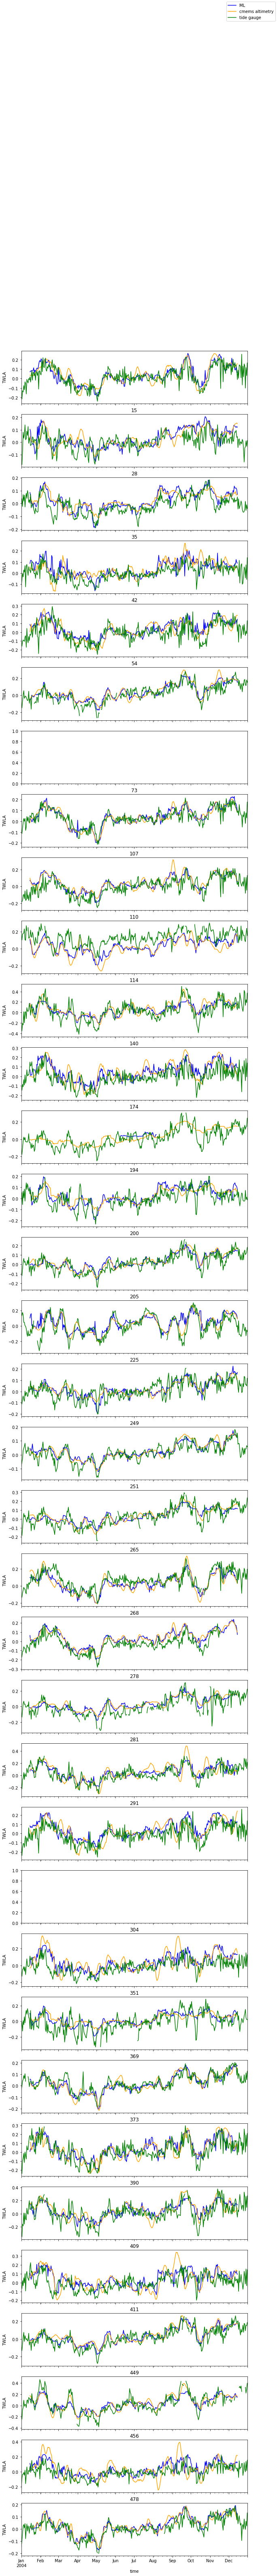

In [15]:
# list_names = ['landsortnorra-010-sweden-smhi','gedser-gedser-denmark-dmi',\
#               'visby-026-sweden-smhi']

#list_names = ['skanor-019-sweden-smhi','kungsholmsfort-008-sweden-smhi',\
#              'simrishamn-017-sweden-smhi']

list_names = ['skanor-019-sweden-smhi']

corr_ML=np.empty(np.size(tg_dac.x))*np.nan
corr_cmems=np.empty(np.size(tg_dac.x))*np.nan

rms_ML=np.empty(np.size(tg_dac.x))*np.nan
rms_cmems=np.empty(np.size(tg_dac.x))*np.nan

std_ML=np.empty(np.size(tg_dac.x))*np.nan
std_cmems=np.empty(np.size(tg_dac.x))*np.nan
std_tg=np.empty(np.size(tg_dac.x))*np.nan


row_index = np.array([0,0,0])
#col_index = np.array([0,1,2])
col_index = np.arange(0,np.size(tg_dac.x))

fig, axs = plt.subplots(np.size(tg_dac.x), 1, sharex=True, sharey=False, figsize=(10,100))

#fig_b, axs_b = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,12))

counter = 0


#for tide_gauge_name in list_names :

for count_TG in tg_dac.x[0:] :

    #radius_of_distance_km = 100
    #tide_gauge_name='visby-026-sweden-smhi'
    
    start_lat = np.asarray(tg_dac.lat[count_TG].values,dtype=float)
    start_lon = np.asarray(tg_dac.lon[count_TG].values,dtype=float)

#     if region in {'BALTIC'} :
#         tide_gauge_name = tg_dac.name[count_TG]
#         tg_due = tg_dac.where(tg_dac.name==tide_gauge_name, drop=True)
#         tide_gauge_name = tg_dac.name[count_TG]
#     else:
    tide_gauge_name = tg_dac.index[count_TG]
    tg_due = tg_dac
    

    ## TIDE CORRECTION

    # dates = []

    # for j in range(-1,24*28*365+5):
    #      dates.append(np.array([datetime(1993, 1, 1, 0, 0, 0) + 
    # timedelta(hours=1+j)]))

    # dates = np.ravel(dates)

    # plt.figure(figsize=(15,5),dpi=320)

    # tide_correction_fes = pd.read_csv("/DGFI8/H/work_marcello/giussani_machinelearning_data/TG/landsortnorra-010-sweden-smhi_fes_ocean.txt",header=None)/100

    # plt.plot(dates,tide_correction_fes,)

    # plt.plot(tg_due.date_time,tg_due.sealevel-tide_correction_fes)
    # plt.ylabel('m')




    # initialise data of lists.
#     if region in {'BALTIC'} :
#         data = {'time':tg_due.time.values,
#                 'sla_dac':np.squeeze(tg_due.sla_dac.values)}
#     else:
    data = {'time':tg_due.time.values,
            'sla_dac':tg_due.sla[:,count_TG]}    
    #break

    # Create DataFrame
    tg = pd.DataFrame(data)
    
    # Remove mean from the tide gauge
    mean_tg_due= tg["sla_dac"].mean()
    tg.sla_dac = tg.sla_dac - tg["sla_dac"].mean()    
    median_tg_due= tg["sla_dac"].median()
    mad_tg_due= tg["sla_dac"].mad()    
    
    # Remove outliers from the tide gauge    
    tg.loc[tg["sla_dac"] > median_tg_due+1.4826*2*mad_tg_due] = np.nan
    tg.loc[tg["sla_dac"] < median_tg_due-1.4826*2*mad_tg_due] = np.nan
    
    tg=tg.set_index(tg.time)
    tg=tg.loc['2004-01-01':'2004-12-31']
    
    tg = tg.groupby(pd.Grouper(freq='24H')).mean()

    #means_tg = tg.groupby(pd.Grouper(freq='3H')).mean()
    
    

    

    #alti
    alti=alti_full.loc['2004-01-15':'2004-12-15']
    #alti_only2004=alti_only2004.loc['2004-11-20':'2004-11-29']
    copernicus=copernicus_full.loc['2004-01-15':'2004-12-15']
    cmems=cmems_full.loc['2004-01-15':'2004-12-15']
    
    

    # Compute distances from tide gauges 
    
    distances_km = haversine_distance(start_lat, start_lon, alti.lat, alti.lon)
    #distances_km_only2004 = haversine_distance(start_lat, start_lon, alti_only2004.lat, alti_only2004.lon)
    distances_km_copernicus = haversine_distance(start_lat, start_lon, copernicus.lat, copernicus.lon) 
    distances_km_cmems = haversine_distance(start_lat, start_lon, cmems.lat, cmems.lon)

    alti['distances_km']=distances_km
    #alti_only2004['distances_km']=distances_km
    copernicus['distances_km']=distances_km_copernicus
    cmems['distances_km']=distances_km_cmems

    alti.dropna(subset = ["sla_predicted"], inplace=True)
    copernicus.dropna(subset = ["sla_predicted"], inplace=True)
    cmems.dropna(subset = ["sla_predicted"], inplace=True)
    

    #alti = alti[distances_km<radius_of_distance_km]
    #copernicus = copernicus[distances_km_copernicus<radius_of_distance_km]
    #cmems = cmems[distances_km_cmems<radius_of_distance_km]
    
    
    alti = alti.loc[alti['distances_km'] == np.nanmin(alti['distances_km'])]
    copernicus = copernicus.loc[copernicus['distances_km'] == np.nanmin(copernicus['distances_km'])]
    cmems = cmems.loc[cmems['distances_km'] == np.nanmin(cmems['distances_km'])]
    #cmems = cmems.loc[np.abs(cmems['distances_km'] - np.nanmin(alti['distances_km']))<5]
    
    

#     alti = alti.loc[alti['distances_km'] <20]
#     copernicus = copernicus.loc[copernicus['distances_km'] <20]
#     cmems = cmems.loc[cmems['distances_km'] <20]
 
    
    #alti = alti.iloc[[np.nanargmin(distances_km)]]
    #copernicus = copernicus.iloc[[np.nanargmin(distances_km_copernicus)]]
    #cmems = cmems.iloc[[np.nanargmin(distances_km_cmems)]]


    alti = alti.groupby(['time']).mean()
    copernicus = copernicus.groupby(['time']).mean()
    cmems = cmems.groupby(['time']).mean()
    
    
    #Check that time series are not too short and that they have a similar number of data
#     if np.shape(alti)[0] < 120 or np.shape(cmems)[0] < 120 or np.shape(tg.sla_dac)[0]<120 or np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
#         if counter == 0 :
#             fig.legend()        
#         counter = counter + 1
#         continue
        
    if np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
        if counter == 0 :
            fig.legend()        
        counter = counter + 1
        continue        
    
    
    freq = 1./10  # Hours
    window_size = 60
    


    
    # LOESS FILTER IN TIME
#     lowess_sm = sm.nonparametric.lowess
#     points_to_filter = 10 #100 points along-track correspond to about 60 km
#     frac_loess = points_to_filter/np.size(alti.sla_predicted)
#     alti.sla_predicted = lowess_sm(np.asarray(alti.sla_predicted),np.asarray(alti.times),frac=frac_loess,it=3, return_sorted = False,missing='drop')
#     cmems.sla_predicted = lowess_sm(np.asarray(cmems.sla_predicted),np.asarray(cmems.times),frac=frac_loess,it=3, return_sorted = False,missing='drop')
    

    # Oversample daily cmems to hourly values
    #cmems_oversample = cmems
    #cmems_oversample = cmems.resample('3H').pad()
    
    
#     means_alti = alti.groupby(pd.Grouper(freq='24H')).mean()
#     means_alti.sla_predicted = np.convolve(means_alti.sla_predicted, np.ones(7)/7, mode='same')
    
#     means_copernicus  = copernicus.groupby(pd.Grouper(freq='24H')).mean()
#     means_cmems  = cmems.groupby(pd.Grouper(freq='24H')).mean()
#     means_tg = tg.groupby(pd.Grouper(freq='24H')).mean()    
    

    # Plot of the products
    try:
        ref = alti.sla_predicted.plot(ax=axs[col_index[counter]],label="ML",title=tide_gauge_name.values,color='blue')
    except:
        pass
    #copernicus.sla_predicted.plot(ax=axs[col_index[counter]],label="model")
    try:
        cmems.sla_predicted.plot(ax=axs[col_index[counter]],label="cmems altimetry",color='orange')
    except:
        pass
    tg.sla_dac.plot(ax=axs[col_index[counter]],label="tide gauge",color='green')  
    ref.set_ylabel("TWLA")
    if counter == 0 :
        fig.legend()
    
    
    
    


    # Plot of the daily products
#     means_alti.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="ML")
#     means_copernicus.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="model")
#     means_cmems.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="cmems altimetry")
#     means_tg.sealevel.plot(ax=axs[row_index[counter],col_index[counter]],label="tide gauge")
#     if counter == 0 :
#         fig.legend()
    
    
    
    #Correlation Analysis

    #HIGH RES

    data = [alti["sla_predicted"], copernicus["sla_predicted"], cmems["sla_predicted"], tg["sla_dac"]]

    headers = ["ML", "model", "cmems", "TG"]

    df = pd.concat(data, axis=1, keys=headers)

    #df = {'alti': np.asarray(alti.sla_predicted), 'copernicus': np.asarray(copernicus.sla_predicted), 'tg': np.asarray(tg.sealevel)}
    correlation_df = df.corr()
    print(tide_gauge_name)
    print(correlation_df)
    
    

    
    print("RMSE ML TG")
    print(np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))
          
    print("RMSE CMEMS TG")
    print(np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))          
   
    corr_ML[count_TG]=correlation_df.values[0,3]
    corr_cmems[count_TG]=correlation_df.values[2,3]
    
    rms_ML[count_TG]=np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean())
    rms_cmems[count_TG]=np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean())  
    
#     stddiff_ML[count_TG]=np.std(alti["sla_predicted"]) - np.std(tg["sla_dac"]) 
#     stddiff_cmems[count_TG]=  np.std(cmems["sla_predicted"]) - np.std(tg["sla_dac"])    
    
    std_ML[count_TG]=scipy.stats.iqr(alti["sla_predicted"],nan_policy='omit')#np.rms(alti["sla_predicted"]) 
    std_cmems[count_TG]=  scipy.stats.iqr(cmems["sla_predicted"],nan_policy='omit')#np.rms(cmems["sla_predicted"])
    std_tg[count_TG]=  scipy.stats.iqr(tg["sla_dac"],nan_policy='omit')#np.rms(tg["sla_dac"])    
    
    counter = counter + 1
    
    #break
    

Mean difference in correlation ML - CMEMS (%)
7.937538933826967
Mean difference in RMS ML - CMEMS (%)
-7.427435481859229


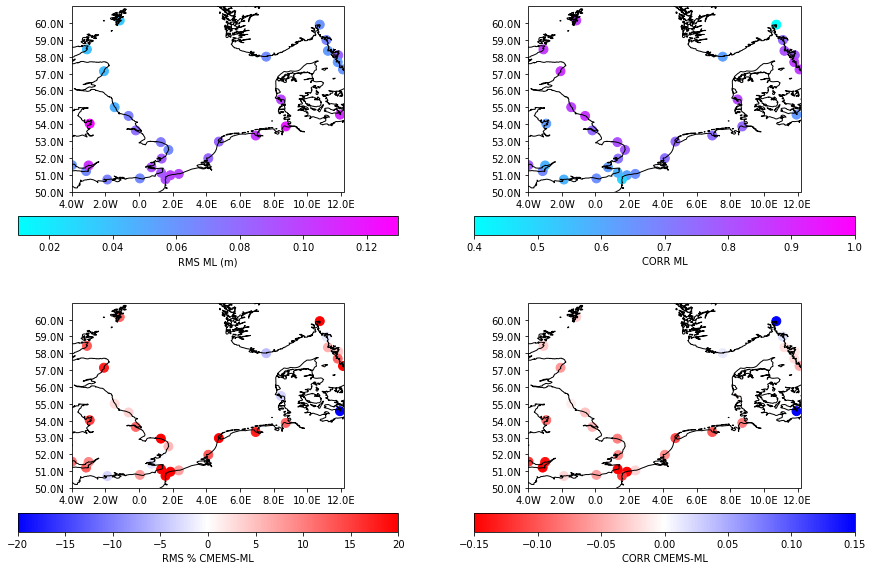

In [16]:
# FUNCTION TO PLOT SINGLE INSTANTANEOUS MAPS -  to be externalised

def single_plot(rms_cmemsvsML_plot,min_sl,max_sl,counter,row_total,col_total,fig,min_lat,max_lat,min_lon,max_lon,label_string,colormap):

    lon = rms_cmemsvsML_plot[0,:]
    lat = rms_cmemsvsML_plot[1,:]
    ssh = rms_cmemsvsML_plot[2,:]   
    
    """Displaying the unstructured grid in a scatterplot:"""
    # 

    #fig = plt.plot()
    #plt.rcParams.update({'font.size': 15})
    #plt.plot
    #plt.rcParams["figure.figsize"] = (50,10) #Increase figure size
    ax=fig.add_subplot(row_total,col_total,counter,projection=ccrs.PlateCarree())
    
    ax.set_xticks(np.arange(min_lon,max_lon,2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat,max_lat,1), crs=ccrs.PlateCarree())    
    
    #ax = plt.axes(projection=ccrs.Miller()) 
    img=plt.scatter(lon, lat, c=ssh, s=80, cmap=colormap, alpha=1) 
    ax.coastlines(resolution='10m', color='black', linewidth=1) 
    plt.xlim(min_lon,max_lon)

    lon_formatter = cart.mpl.ticker.LongitudeFormatter(number_format='.1f', 
                                      degree_symbol='', 
                                      dateline_direction_label=True)
    lat_formatter = cart.mpl.ticker.LatitudeFormatter(number_format='.1f', 
                                     degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 
    plt.colorbar(img,label=label_string,orientation = 'horizontal',pad = 0.1)
    plt.clim(min_sl, max_sl)
    
    ax.set_extent([min_lon,max_lon,min_lat,max_lat,])
    #plt.show() #a window will show up, allowing the user to see and download the plot
    
    return 




# Corr and RMS of ML
rms_ML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),rms_ML,])
corr_ML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),corr_ML,])


# Absolute differences in RMS, Correlation and standard deviation
rms_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),rms_cmems-rms_ML,])
corr_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),corr_cmems-corr_ML,])

# Percentage differences in RMS and Correlation
rms_pc_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),((rms_cmems-rms_ML)/rms_ML)*100,])
corr_pc_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),((corr_cmems-corr_ML)/corr_ML)*100,])


fig = plt.figure(figsize = (15, 10))

min_sl = 0.01
max_sl = 0.13
single_plot(rms_ML_plot,min_sl,max_sl,1,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'RMS ML (m)','cool')

min_sl = 0.4
max_sl = 1.0
single_plot(corr_ML_plot,min_sl,max_sl,2,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'CORR ML','cool')


# min_sl = -0.01
# max_sl = 0.01
# single_plot(rms_cmemsvsML_plot,min_sl,max_sl,3,3,2,fig,min_lat,max_lat,min_lon,max_lon,r'RMS CMEMS-ML (m)','bwr')

min_sl = -20
max_sl = 20
single_plot(rms_pc_cmemsvsML_plot,min_sl,max_sl,3,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'RMS % CMEMS-ML','bwr')

if region in {'BALTIC'} :
    min_sl = -0.05
    max_sl = 0.05
elif region in {'NORTHSEA'} :  
    min_sl = -0.15
    max_sl = 0.15    
    
single_plot(corr_cmemsvsML_plot,min_sl,max_sl,4,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'CORR CMEMS-ML','bwr_r')

# if region in {'BALTIC'} :
#     min_sl = -5
#     max_sl = 5
# elif region in {'NORTHSEA'} :
#     min_sl = -15
#     max_sl = 15
# single_plot(corr_pc_cmemsvsML_plot,min_sl,max_sl,6,3,2,fig,min_lat,max_lat,min_lon,max_lon,r'CORR % CMEMS-ML','bwr_r')


# Correlation
print('Mean difference in correlation ML - CMEMS (%)')
print(np.nanmean((corr_ML - corr_cmems) / corr_cmems * 100))

# RMS
print('Mean difference in RMS ML - CMEMS (%)')
print(np.nanmean((rms_ML - rms_cmems) / rms_cmems *100))

fig.savefig("fig_corr_rms.png")


Average misrepresented signal in ML (%)
1.6654240510465033
Average misrepresented signal in CMEMS (%)
7.166284128398078


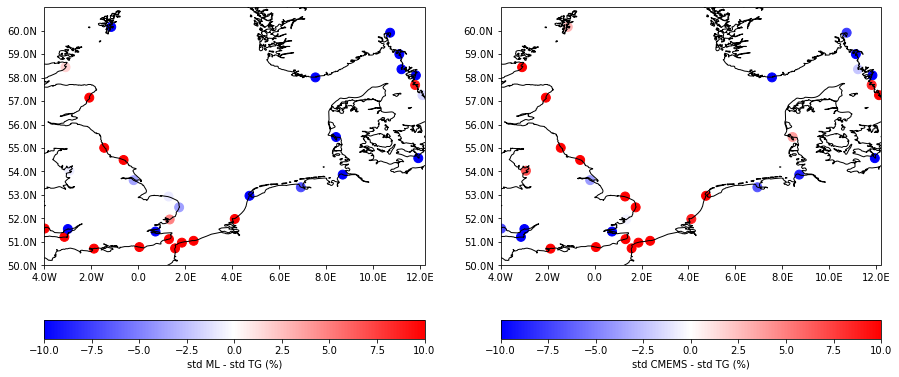

In [17]:
#Standard Deviations

stddiff_ML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),(std_ML-std_tg)/std_tg *100,])

stddiff_cmems_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),(std_cmems-std_tg)/std_tg *100,])


fig = plt.figure(figsize = (15, 10))

min_sl = -10
max_sl = 10
single_plot(stddiff_ML_plot ,min_sl,max_sl,1,1,2,fig,min_lat,max_lat,min_lon,max_lon,r'std ML - std TG (%)','bwr')


single_plot(stddiff_cmems_plot,min_sl,max_sl,2,1,2,fig,min_lat,max_lat,min_lon,max_lon,r'std CMEMS - std TG (%)','bwr')


print('Average misrepresented signal in ML (%)')
print(np.nanmean( (std_ML-std_tg)/std_tg *100)) 

print('Average misrepresented signal in CMEMS (%)')
print(np.nanmean( (std_cmems-std_tg)/std_tg *100) )




#### 

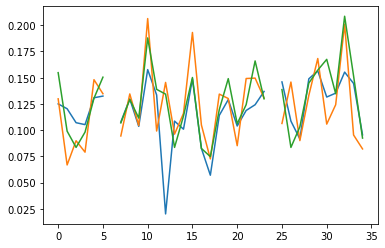

In [18]:
plt.plot(std_ML)
plt.plot(std_tg)
plt.plot(std_cmems)